## BLIP_feature_extractor

In [ ]:
!pip install pytorch_pretrained_vit

In [2]:
import sys
import json
import PIL
import pickle 
import pathlib
import re
import os
import torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR100, MNIST
from torchvision import transforms
from tqdm import trange
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from pytorch_pretrained_vit import ViT
from tqdm import tqdm, trange
from collections import Counter
from scipy.optimize import linear_sum_assignment
import math

In [ ]:
#Mount drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Load text data
TEXT_DATASET_FILE = "/content/drive/MyDrive/BLIP/data/painting_descriptions.pickle"
text_dataset_path = f"{TEXT_DATASET_FILE}"
text_dataset = pickle.load(open(text_dataset_path,"rb"))
print(text_dataset.keys())

In [ ]:
!git clone https://github.com/salesforce/LAVIS.git

In [ ]:
!cd LAVIS/

In [ ]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/salesforce/LAVIS
    %cd LAVIS
    !pip install .

In [ ]:
from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor

In [ ]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [ ]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip2_feature_extractor", model_type="pretrain", is_eval=True, device=device)
#image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

In [ ]:
#Extract features
painting_ids, image_features, text_features, image_inputs, text_inputs, multimodal_features = [], [], [], [], [], []

image_files_names = os.listdir("/content/drive/MyDrive/BLIP/data/images/")
painting_ids_dict = dict.fromkeys(text_dataset["painting_ids"], "YES")

for i in range(0, len(image_files_names)):
    painting_name = re.sub(".jpg", "", image_files_names[i])
    if painting_name in painting_ids_dict.keys():
        painting_ids.append(painting_name)
        idx_of_painting = text_dataset["painting_ids"].index(painting_name)
        
        text_input = text_dataset["painting_descriptions:"][idx_of_painting]
        text_input = (text_input[:77] + '..') if len(text_input) > 77 else text_input

        
        #text_input = clip.tokenize(text_input).to(device)
        text_input = txt_processors["eval"](text_input)
        
        im = Image.open(pathlib.Path(f"/content/drive/MyDrive/CLIP (1)/data/images/{image_files_names[i]}")).convert("RGB")
        #image_input = preprocess(im).unsqueeze(0).to(device)
        image = vis_processors["eval"](im).unsqueeze(0).to(device)

        sample = {"image": image, "text_input": [text_input]}
        with torch.cuda.amp.autocast(enabled=(device != torch.device("cpu"))):
          features_multimodal = model.extract_features(sample)

          features_image = model.extract_features(sample, mode="image")
          features_text = model.extract_features(sample, mode="text")     
          
          
          image_inputs.append(image)
          text_inputs.append(text_input)

          image_features.append(features_image)
          text_features.append(features_text)
          multimodal_features.append(features_multimodal)

In [ ]:
all_img_features = []
for features_image in image_features:
  image_feat = features_image.image_embeds_proj[:,0,:]
  image_feat = image_feat.cpu().numpy()
  all_img_features.append(image_feat)

all_img_features = torch.tensor(all_img_features).detach().cpu().numpy()

In [ ]:
all_text_features = []

for features_text in text_features:
  text_feat = features_text.text_embeds_proj[:,0,:]
  text_feat = text_feat.cpu().numpy()
  all_text_features.append(text_feat)

all_text_features = torch.tensor(all_text_features).detach().cpu().numpy()

In [ ]:
#save features

In [ ]:
np.save('/content/drive/MyDrive/BLIP/blip_features_ext.npy', [all_img_features, all_text_features])

In [3]:
all_img_features, all_text_features = np.load('/Users/bereket.yilma/Documents/Projects/CLIP/features_blip_random.npy')

In [4]:
all_img_features.shape

(2324, 1, 256)

In [5]:
all_text_features.shape

(2324, 1, 256)

In [6]:
all_img_features = np.squeeze(all_img_features) 

In [7]:
all_text_features = np.squeeze(all_text_features) 

In [8]:
all_img_features.shape

(2324, 256)

In [9]:
all_text_features.shape

(2324, 256)

In [10]:
all_img_features

array([[ 0.1259088 ,  0.05305685,  0.05779792, ..., -0.05906971,
        -0.10822371,  0.00447004],
       [ 0.07954136,  0.03945908,  0.06568762, ..., -0.01451855,
        -0.12321135,  0.04091787],
       [ 0.07640432, -0.00278882,  0.06970327, ..., -0.00516679,
        -0.11265621,  0.04811149],
       ...,
       [ 0.07127719, -0.0158829 , -0.01734451, ..., -0.04775774,
        -0.08614074,  0.03568735],
       [ 0.0901676 ,  0.03549921,  0.0531741 , ..., -0.01211002,
        -0.07573661,  0.0799341 ],
       [ 0.07123796,  0.04506326,  0.06779051, ..., -0.01294783,
        -0.06164102, -0.01409469]], dtype=float32)

## Visualize MOdality gap

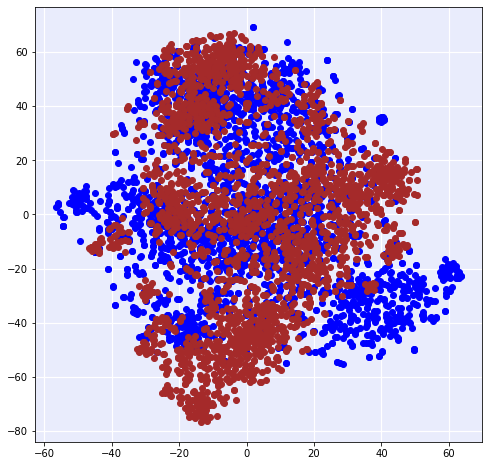

In [16]:
import warnings; warnings.simplefilter('ignore')

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(all_text_features)
projections1 = tsne.fit_transform(all_img_features)
#fig = px.scatter(projections, x=0, y=1, title="test")
#fig.show()
#fig.write_image(f'{plot_name}.pdf')
plt.figure(figsize=(8, 8))
ax = plt.axes()

ax.set_facecolor("#e9ecfc")
ax.grid(which='major', color='white', linewidth=1.2)
ax.grid(which='minor', color='white', linewidth=0.6)
ax.set_axisbelow(True)

plt.scatter(projections[:,0],projections[:,1], c='blue')
plt.scatter(projections1[:,0],projections1[:,1], c='brown')
#plt.scatter(projections1, c='red')

plt.savefig('BLIP.pdf')  
 

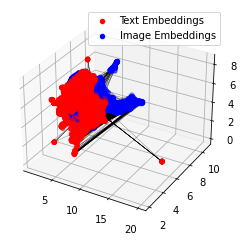

In [20]:
import umap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Initialize a UMAP model
umap_model = umap.UMAP(n_components=3)

# Fit and transform the text embeddings
text_projections = umap_model.fit_transform(all_text_features)

# Fit and transform the image embeddings
img_projections = umap_model.fit_transform(all_img_features)

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the text embeddings
ax.scatter(text_projections[:, 0], text_projections[:, 1], text_projections[:, 2], c='r', label='Text Embeddings')

# Plot the image embeddings
ax.scatter(img_projections[:, 0], img_projections[:, 1], img_projections[:, 2], c='b', label='Image Embeddings')

# Iterate over the data points and draw a line between the corresponding text and image embeddings
for i in range(len(text_projections)):
    ax.plot([text_projections[i, 0], img_projections[i, 0]], [text_projections[i, 1], img_projections[i, 1]], [text_projections[i, 2], img_projections[i, 2]], 'k-', lw=0.2)

# Add a legend and show the plot
plt.legend()
plt.show()
